# CX Machine Translation services usage analysis

**Krishna Chaitanya Velaga, Data Scientist III, Wikimedia Foundation**

**Last Update: 25 October 2023**

[Ticket](https://phabricator.wikimedia.org/T338606) | [Codebase](https://github.com/wikimedia-research/machine-translation-service-analysis)

# Table of Contents

1. [Purpose](#Purpose)
2. [Methodology](#Methodology)
3. [Overall usage by machine translation service](#Overall-usage-by-machine-translation-service)
    * [YoY comparision](#YoY-comparision)
4. [Daily published translations](#Daily-published-translations)
5. [Usage by language pair](#Usage-by-language-pair) 
6. [Usage at each target language](#Usage-at-each-target-language)
7. [Percent machine translation content is modified](#Percent-machine-translation-content-is-modified)
8. [Percent of articles that are created with each MT service and deleted](#Percent-of-articles-that-are-created-with-each-MT-service-and-deleted)
    

# Purpose
Content translation supports multiple machine translation services.  When multiple options are available for a language, even if one is provided by default, users can use a different service. 
[See default configuration](https://www.mediawiki.org/wiki/Help:Content_translation/Translating/Initial_machine_translation?useskin=vector-2022#Machine_translation_availability) and [languages supported](https://www.mediawiki.org/wiki/Help:Content_translation/Translating/Initial_machine_translation?useskin=vector-2022#Machine_translation_availability) files for details on all available language pairs and defaults. 

The purpose of the report is to understand the usage of MT services across various languages, and if needed inform changes to default service provided on certain language pairs. The previous iterations of the report have been run in May 2022 and later again in October 2022, to track changes due to [T309266](https://phabricator.wikimedia.org/T309266), [T307970](https://phabricator.wikimedia.org/T307970), and [T308248](https://phabricator.wikimedia.org/T308248). 

In this report, along with overall usage, we are specifically interested in the [MinT](https://www.mediawiki.org/wiki/MinT), which has exposed several translation models such as NLLB-200 and Opus to many languages.

# Methodology

For each machine translation service, we compared the following:
* Percent of translations published by each machine translation service:
    * Overall across all languages
    * Daily usage trends
    * Usage at each Language Pair (Source - Target)
    * Most frequently used service for each target Language
* Percent each machine translation service was modified by users
* Percent of articles created with each machine translation service that were deleted.

Data comes from the following sources:
* [cx_corpora table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_corpora_table)
* [cx_translations table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_translations_table)

**All published translations from from August to September 2023 were considered for analysis.**

# Summary
**Overall usage**<br>
* Google Translate, which can be used to translate into all available languages except English, has been used for majority of the translations (81.35%) of the published translations across all language paris.
* MinT (Machine in Translation) which is a Wikimedia Foundation hosted open-source machine translation service, is now the second most used transaltion service accounting for 6.89% percent of all published translations. 
* No machine translation was used (scratch) for 6% of the published translations.

**YoY comparision**<br>*We compared the period of current analysis (August to September 2023) to the same period last year (August to September 2022) to observe changes in service usage.*
* The most significant change has been MinT now being the second most used translation service.
* Although Google is still the most used service, it's usage reduced by 5 percent points (86.44% to 81.35%).
* There has been slight increase (2 percent points; 3.95% to 6%) in percentage of translation that used no MT service (scratch).
* While Apertium's usage increased slightly, Yandex's usage decreased slightly.

**Languge pairs where an optional service was used more or close to the default**<br>*having at least five published translations*
* There are 24 language pairs where an optional service was used more or close to the default.
* In 50% of the cases, largely where Google was the default service, there are sustantial number of translations where no MT service was used (scratch).
* In 25% of the cases, Google was used more than the default service.
* Although, MinT is the default for en-zu, Google was used for 97% of the translations.
* For en-ku & en-st, MinT was used more than Google (the default service).

# imports anmd functions

In [53]:
import pandas as pd
import duckdb
import numpy as np
import warnings


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from IPython.display import display_html
from IPython.display import display, HTML

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import kaleido

In [48]:
init_notebook_mode(connected=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

bold = '\033[1m'
end = '\033[0m'
underline = '\033[4m'

In [3]:
def pr_centered(content, bold=False):
    if bold:
        content = f"<b>{content}</b>"
    
    centered_html = f"<div style='text-align:center'>{content}</div>"
    
    display(HTML(centered_html))
    
def format_percent(column, df):
    return df[column].map('{:.2%}'.format)

def display_h(frames, space=100):
    html = ""
    
    for key in frames.keys():
        html_df =f'<div>{key} {frames[key]._repr_html_()}</div>'
        html += html_df
        
    html = f"""
    <div style="display:flex; justify-content: space-evenly;">
    {html}
    </div>"""
    
    display_html(html, raw=True)

In [7]:
conn = duckdb.connect('data_gathering/secrets/mt_data.db')

In [8]:
def query(query_string, df=False, conn=conn):
    if df==True:
        return conn.sql(query_string).df()
    else:
        return conn.sql(query_string).show()

In [6]:
conn.close()

# Overall-usage-across-all-languages

In [9]:
mt_compare_overall_2023 = query("""
WITH
    base AS (
        SELECT 
            mt_service,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM 
            mt_logs
        WHERE
            translation_start_time >= '2023-08-01' AND
            translation_start_time <= '2023-09-30'
        GROUP BY
            mt_service
        ORDER BY
            n_translations DESC)


SELECT
    mt_service AS 'Machine translation service',
    n_translations AS 'Number of Translations',
    n_translations / SUM(n_translations) OVER () AS 'Percent of all published translations'
FROM
    base
""", True)

In [10]:
mt_compare_overall_2023_pr = mt_compare_overall_2023.copy()
mt_compare_overall_2023_pr['Percent of all published translations'] = format_percent('Percent of all published translations', mt_compare_overall_2023_pr)

In [11]:
pr_centered('Published translations by machine translations service across all language pairs', True)
pr_centered('August to September 2023')
display_h({
    '':mt_compare_overall_2023_pr.set_index('Machine translation service')
})

,Number of Translations,Percent of all published translations
Machine translation service,,
Google,42896,81.35%
MinT,3634,6.89%
scratch,3164,6.00%
Apertium,1446,2.74%
Yandex,1076,2.04%
Elia,493,0.93%
LingoCloud,22,0.04%


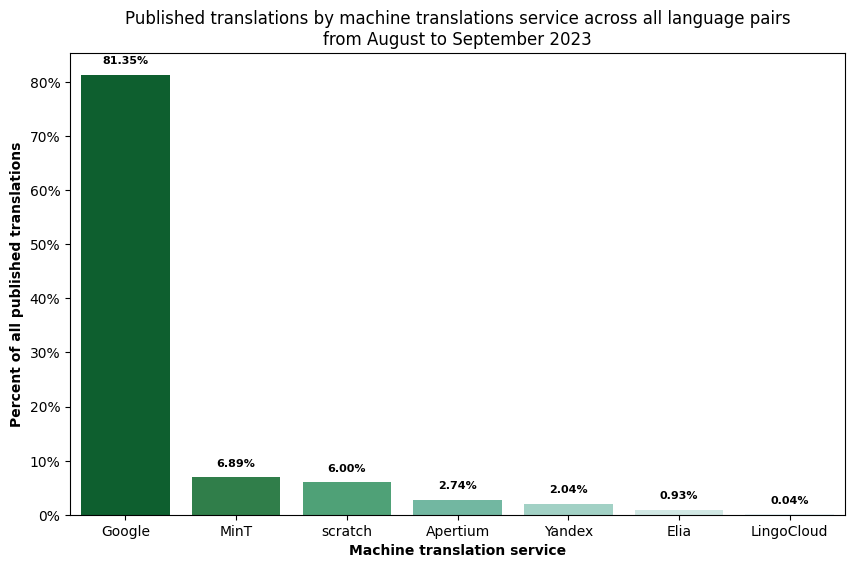

In [12]:
mt_compare_overall_2023['Percent of all published translations'] *= 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mt_compare_overall_2023, x='Machine translation service', y='Percent of all published translations', palette="BuGn_r")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

plt.title("Published translations by machine translations service across all language pairs\nfrom August to September 2023")
plt.xlabel("Machine translation service", fontweight='bold')
plt.ylabel("Percent of all published translations", fontweight='bold')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=8, fontweight='bold', color='black', 
                xytext=(0, 10), textcoords='offset points')

plt.show()

## Compare with 2022

In [13]:
mt_compare_overall_2022 = query("""
WITH
    base AS (
        SELECT 
            mt_service,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM 
            mt_logs
        WHERE
            translation_start_time >= '2022-08-01' AND
            translation_start_time <= '2022-09-30'
        GROUP BY
            mt_service
        ORDER BY
            n_translations DESC)


SELECT
    mt_service AS 'Machine translation service',
    n_translations AS 'Number of Translations',
    n_translations / SUM(n_translations) OVER () AS 'Percent of all published translations'
FROM
    base
""", True)

In [14]:
mt_compare_overall_2022_pr = mt_compare_overall_2022.copy()
mt_compare_overall_2022_pr['Percent of all published translations'] = format_percent('Percent of all published translations', mt_compare_overall_2022)

pr_centered('Published translations by machine translations service across all language pairs', True)
display_h({
    'August to September 2022': mt_compare_overall_2022_pr.set_index('Machine translation service'),
    'August to September 2023': mt_compare_overall_2023_pr.set_index('Machine translation service')
})

,Number of Translations,Percent of all published translations
Machine translation service,,
Google,48456,86.44%
scratch,2216,3.95%
Yandex,2156,3.85%
NLLB-200,1560,2.78%
Apertium,969,1.73%
Elia,625,1.11%
OpusMT,51,0.09%
LingoCloud,22,0.04%
MinT,4,0.01%


## Daily published translations
Translations published per day by each MT service were reviewed to identify any sudden increases or decreases in usage and to determine if those changes corresponded to deployments or setting changes that may have impacted MT availability.






In [15]:
mt_daily = query("""
WITH base AS (
    SELECT 
        mt_service,
        translation_start_time AS date,
        translation_id
    FROM 
        mt_logs
    WHERE
        translation_start_time >= '2022-08-01' AND
        translation_start_time <= '2023-09-30')

SELECT
    date,
    mt_service,
    COUNT(DISTINCT translation_id) AS n_translations
FROM
    base
GROUP BY
    date,
    mt_service
""", True)

In [16]:
warnings.filterwarnings('ignore')
mt_2023_daily = mt_daily.query("""'2023-04-01' <= date <= '2023-09-30'""")
mt_2023_daily.replace([np.inf, -np.inf], np.nan, inplace=True)
mt_2023_daily.dropna(subset=['date', 'n_translations'], inplace=True)

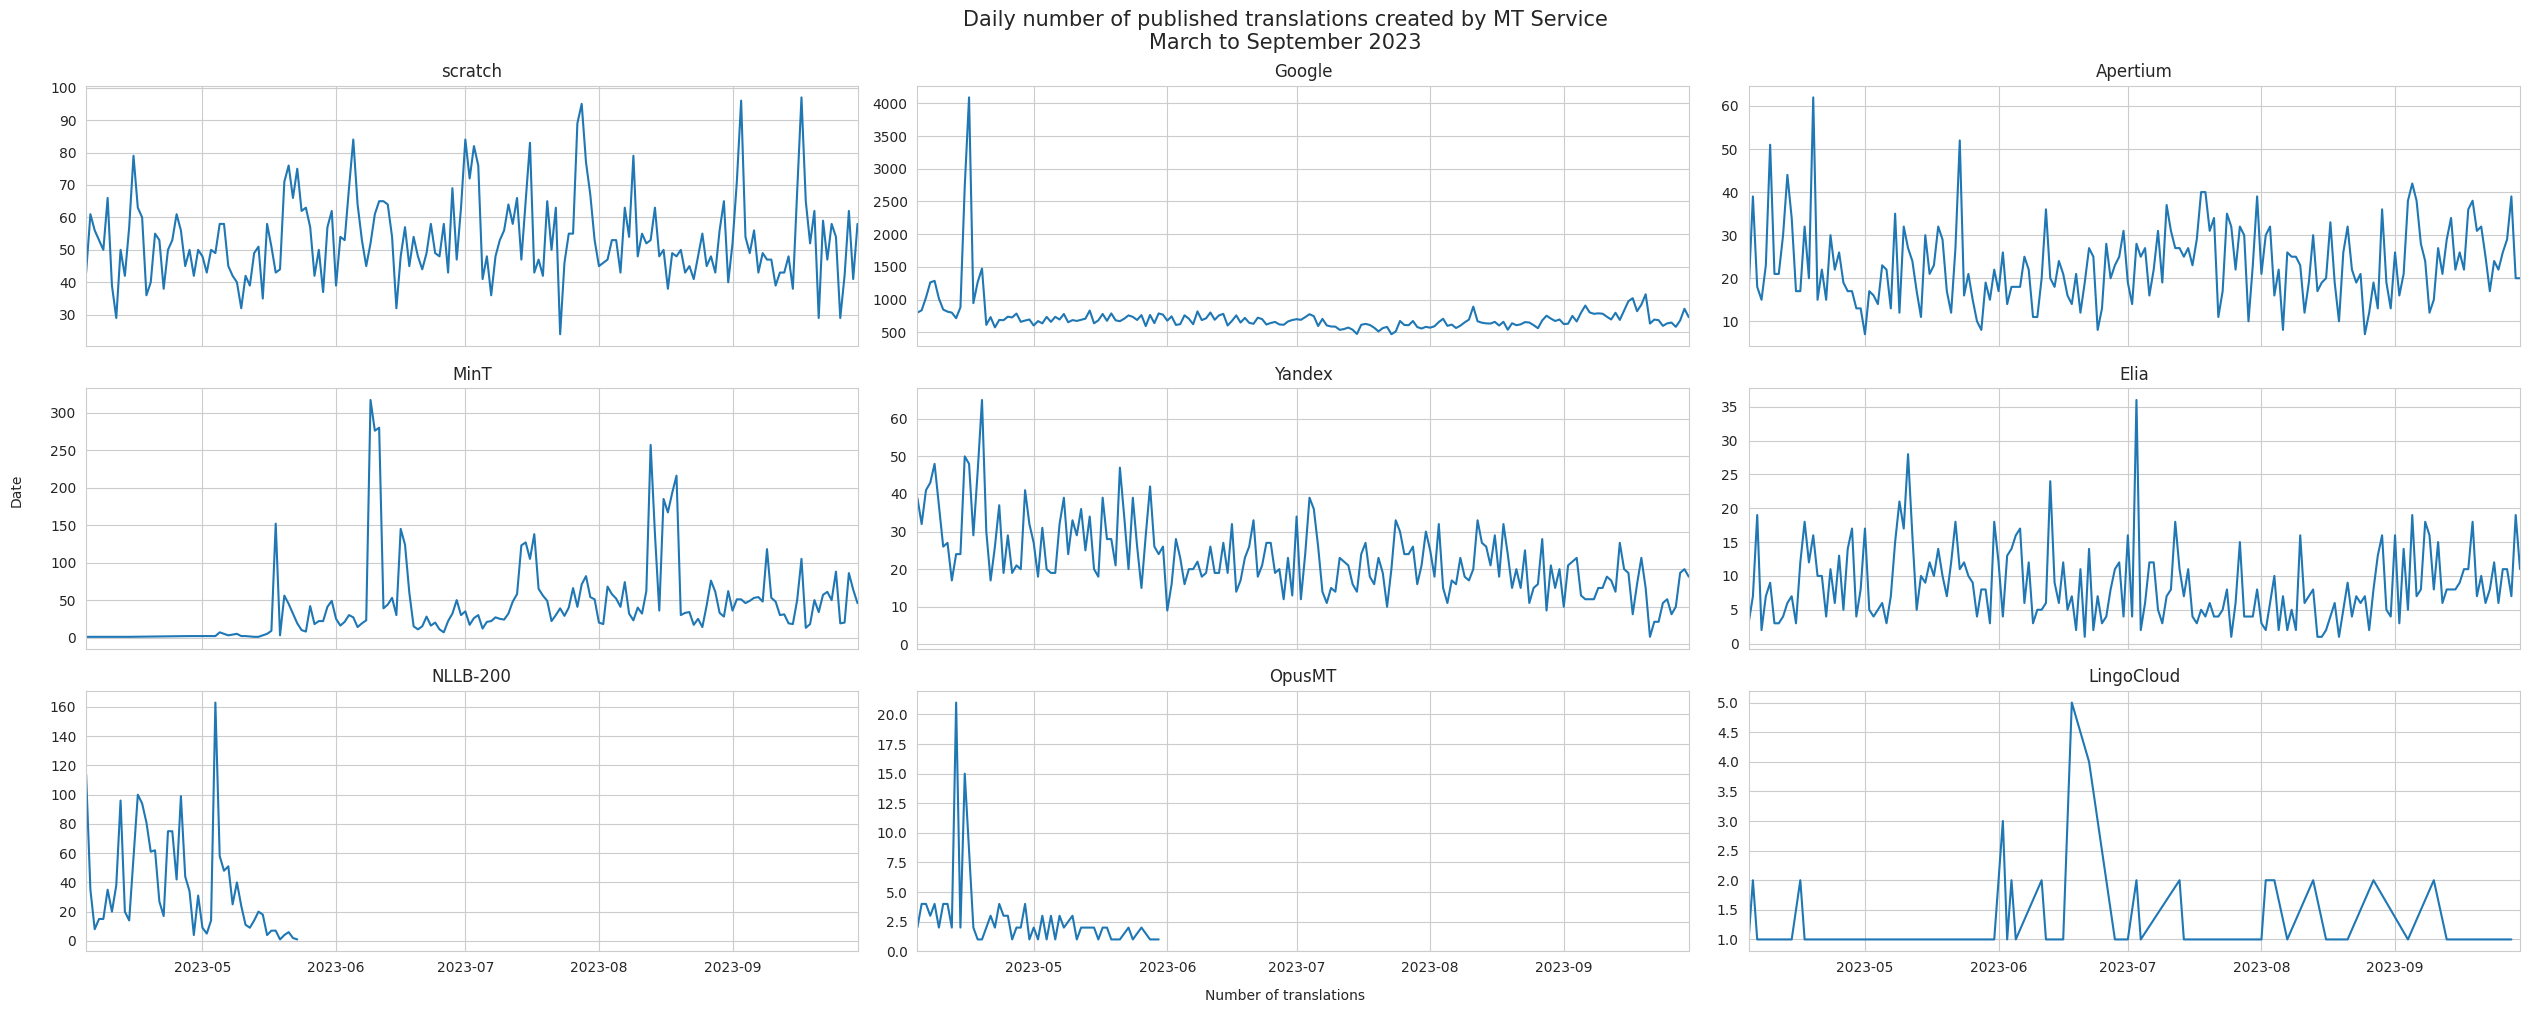

In [17]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(25, 10), sharex=True)

for i, mt_service in enumerate(mt_2023_daily.mt_service.unique()):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    service_data = mt_2023_daily.query(f"mt_service == '{mt_service}'")

    sns.lineplot(data=service_data, x='date', y='n_translations', ax=ax)
    ax.set_title(mt_service)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim(service_data['date'].min(), pd.to_datetime('2023-09-30'))
    
fig.text(0.5, -0.01, 'Number of translations', ha='center')
fig.text(-0.01, 0.5, 'Date', va='center', rotation='vertical')
fig.suptitle("Daily number of published translations created by MT Service\nMarch to September 2023", fontsize=15)

plt.tight_layout()

plt.show()

**Summary**
* With the deployment of MinT, around May/June 2023, NLLB-200's and OpusMT's direct usage ended as these are now integrated into MinT.
* As MinT deployments happened in stages, spikes can be seen at various instances when the MinT was enabled for new language pairs.
* The huge spike in Google's usage in April 2023, is specifically due to increased activity Uzbek Wikipedia, likely due to a translation campaign.
* Compared to 2022, the median number of daily translations from scratch, increased from 34 to 49.

In [18]:
def daily_avg(start_dt, end_dt, df=mt_daily):
    return (
        df    
        .query(f"""'{start_dt}' <= date <= '{end_dt}'""")
        .groupby('mt_service')
        .agg({'n_translations': 'median'})
        .astype(int)
        .sort_values('n_translations', ascending=False)
        .reset_index()
        .rename({
            'mt_service': 'Service', 
            'n_translations': '# Translations'
        }, axis=1)
    )

In [19]:
pr_centered('Number of Daily Translations (Median)', True)
display_h({
    'August to September 2022': daily_avg('2022-08-01', '2022-09-30'),
    'April to May 2023': daily_avg('2023-04-01', '2023-05-31'),
    'August to September 2023': daily_avg('2023-08-01', '2023-09-30')
})

,Service,# Translations
0,Google,760
1,scratch,34
2,Yandex,29
3,Apertium,14
4,NLLB-200,12
5,Elia,8
6,LingoCloud,1
7,MinT,1
8,OpusMT,1
,Service,# Translations


## Usage by language pair
The number and percentage of publications by each machine translation service at each language pair (i.e., source language and target language) were reviewed. Due to the large combination of language pairs, the data was saved to a [Google Spreadsheet](to be linked) to easily filter and identify the percentage of publications by language pair for each machine translation service.

In [20]:
mt_by_langpair = query("""
WITH
    base AS (
        SELECT
            source_language,
            target_language,
            mt_service,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM 
            mt_logs
        WHERE
            translation_start_time >= '2023-08-01' AND
            translation_start_time <= '2023-09-30'
        GROUP BY
            source_language,
            target_language,
            mt_service
        ORDER BY
            source_language,
            target_language,
            n_translations)

SELECT
    *,
    n_translations / SUM(n_translations) OVER (PARTITION BY source_language, target_language) AS pct_translations
FROM
    base
""", True)

In [21]:
mt_by_langpair.to_csv('data_gathering/secrets/mt_usage_langpair.tsv', sep='\t', index=False)

## Languge pairs where an optional service was used more or close to the default

In [22]:
mt_defaults = query("""
WITH
    base AS (
    SELECT
        *,
        source_language||'-'||target_language AS pair
    FROM
        mt_by_langpair mt
    )
    
SELECT 
    b.* EXCLUDE(mt_service),
    b.mt_service AS service_used,
    dfs.service AS default_service
FROM 
    base b
    JOIN mt_defaults dfs
    ON b.pair = dfs.language_pair
WHERE
    service_type = 'default_mt'
""", True)

In [23]:
mt_optional_services_used_more = mt_defaults[
    (mt_defaults['service_used'] != mt_defaults['default_service']) & 
    (mt_defaults['pct_translations'] > 0.25) &
    (mt_defaults['n_translations'] > 5)
]

mt_optional_services_used_more_pr = mt_optional_services_used_more.copy()
mt_optional_services_used_more_pr = (
    mt_optional_services_used_more_pr
    .rename(columns={
        'source_language': 'Source',
        'target_language': 'Target',
        'n_translations': '# Translations',
        'pct_translations': '% of Translations',
        'service_used': 'MT service used',
        'default_service': 'Default service'
    })
    .set_index(['Default service', 'Source']))

mt_optional_services_used_more_pr.sort_values(['Default service', '% of Translations'], ascending=False, inplace=True)
mt_optional_services_used_more_pr['% of Translations'] = format_percent('% of Translations', mt_optional_services_used_more_pr)

In [24]:
pr_centered('Languge pairs where an optional service was used more or close to the default', True)
pr_centered('(having at least five published translations)')
display_h({
    '': mt_optional_services_used_more_pr
})

Target 
 # Translations 
 % of Translations 
 pair 
 MT service used 
 
 
 Default service 
 Source 
 
 
 
 
 
 
 
 
 
 MinT 
 en 
 zu 
 34 
 97.14% 
 en-zu 
 Google 
 
 
 Google 
 en 
 ja 
 46 
 100.00% 
 en-ja 
 scratch 
 
 
 tr 
 en 
 7 
 100.00% 
 tr-en 
 scratch 
 
 
 en 
 de 
 11 
 100.00% 
 en-de 
 scratch 
 
 
 ar 
 en 
 20 
 90.91% 
 ar-en 
 scratch 
 
 
 de 
 lb 
 29 
 90.62% 
 de-lb 
 Yandex 
 
 
 uk 
 be 
 43 
 81.13% 
 uk-be 
 Yandex 
 
 
 fa 
 en 
 33 
 80.49% 
 fa-en 
 scratch 
 
 
 he 
 en 
 11 
 78.57% 
 he-en 
 scratch 
 
 
 be 
 uk 
 7 
 77.78% 
 be-uk 
 Yandex 
 
 
 en 
 ku 
 9 
 75.00% 
 en-ku 
 MinT 
 
 
 fr 
 en 
 11 
 68.75% 
 fr-en 
 scratch 
 
 
 he 
 yi 
 9 
 60.00% 
 he-yi 
 Yandex 
 
 
 en 
 st 
 8 
 57.14% 
 en-st 
 MinT 
 
 
 en 
 id 
 262 
 42.88% 
 en-id 
 scratch 
 
 
 en 
 fa 
 503 
 32.04% 
 en-fa 
 scratch 
 
 
 it 
 fr 
 12 
 31.58% 
 it-fr 
 scratch 
 
 
 ar 
 om 
 9 
 29.03% 
 ar-om 
 scratch 
 
 
 Elia 
 en 
 eu 
 40 
 38.46% 
 en-eu 
 Google 
 
 
 es 
 eu 
 195 
 36.72% 
 es-eu 
 Google 
 
 
 Apertium 
 es 
 en 
 11 
 64.71% 
 es-en 
 scratch 
 
 
 en 
 gl 
 67 
 50.00% 
 en-gl 
 Google 
 
 
 nl 
 af 
 8 
 50.00% 
 nl-af 
 Google 
 
 
 es 
 ca 
 128 
 35.16% 
 es-ca 
 Google

## Usage at each target language
Next, a closer look was taken at each machine translation service, identifying its usage at all target languages where available and determining the languages each service is helping to support the most.

In [25]:
def chart_order_services(services, selected_service):
    services.remove(selected_service) 
    services.sort()
    services.insert(0, selected_service)
    return services

In [59]:
def chart_usage(service, min_translations=10, min_percent=0.1, chart_height=750, chart_width=1400, xlabel_offset=0.025, return_fig=False):
    service_usage_by_target = query(f"""
        WITH
            languages AS (
                SELECT 
                    DISTINCT target_language
                FROM 
                    mt_logs
                WHERE
                    translation_start_time >= '2023-08-01' 
                    AND translation_start_time <= '2023-09-30' 
                    AND mt_service = '{service}'),

            base AS (
                SELECT
                    *
                FROM
                    mt_logs
                WHERE
                    target_language IN (SELECT target_language FROM languages)
                    AND translation_start_time >= '2023-08-01' 
                    AND translation_start_time <= '2023-09-30' ),

            agg AS (
                SELECT
                    target_language,
                    mt_service,
                    COUNT(DISTINCT translation_id) AS n_translations
                FROM
                    base
                GROUP BY
                    target_language,
                    mt_service
                ORDER BY
                    target_language,
                    n_translations DESC)
                    
        SELECT
            *,
            n_translations / SUM(n_translations) OVER (PARTITION BY target_language) AS pct_translations
        FROM
            agg
        """, True)
    
    top_langs = (
        service_usage_by_target
        .query(f"""(mt_service == @service) & (n_translations >= {min_translations}) & (pct_translations > {min_percent})""")
        .sort_values(['pct_translations'], ascending=False)
        .target_language
        .values
        .tolist()
    )
    
    top_langs_usage = (
        service_usage_by_target
        .query("""target_language == @top_langs""")
        .assign(
            target_language=lambda df: pd.Categorical(
                df['target_language'], 
                categories=top_langs, 
                ordered=True),
            mt_service=lambda df: pd.Categorical(
                df['mt_service'], 
                categories=chart_order_services(df.mt_service.unique().tolist(), service), 
                ordered=True)
        )
        .sort_values(['target_language', 'mt_service'])
    )
    
    fig = px.bar(top_langs_usage, 
                 y='target_language', 
                 x='pct_translations', 
                 color='mt_service', 
                 orientation='h', 
                 height=chart_height, 
                 width=chart_width,
                 color_discrete_sequence=px.colors.qualitative.T10,
                 labels={
                     'target_language': 'Target language', 
                     'pct_translations': 'Percent of all published translations', 
                     'mt_service': 'MT service'
                 },
                 title=f'Languages most supported by {service} (by percentage of published translations)',
                 category_orders={'target_language': top_langs})
    
    fig.update_xaxes(tickformat=".0%")
    annotations = []
    
    for _, row in top_langs_usage.iterrows():
        if row['mt_service'] == service:
            annotations.append(
                dict(
                    x=row['pct_translations'] - xlabel_offset,
                    y=row['target_language'],
                    text=f"{row['pct_translations']:.0%}",
                    showarrow=False,
                    font=dict(color="white")
                )
            )
            
    fig.update_layout(annotations=annotations)
    
    if return_fig:
        return fig
    else:
        fig.show()

In [27]:
print(f'Available services: {mt_by_langpair.mt_service.unique().tolist()}')

Available services: ['MinT', 'Google', 'Yandex', 'scratch', 'Apertium', 'Elia', 'LingoCloud']


### MinT

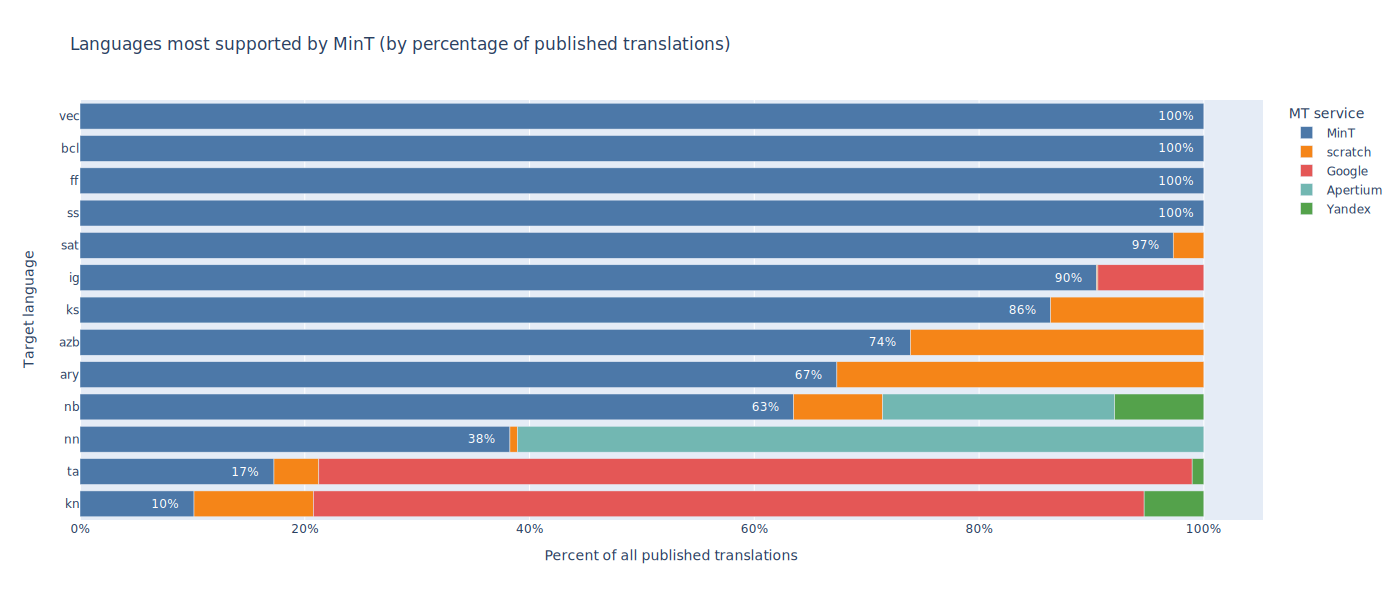

In [36]:
chart_usage('MinT', chart_height=600)

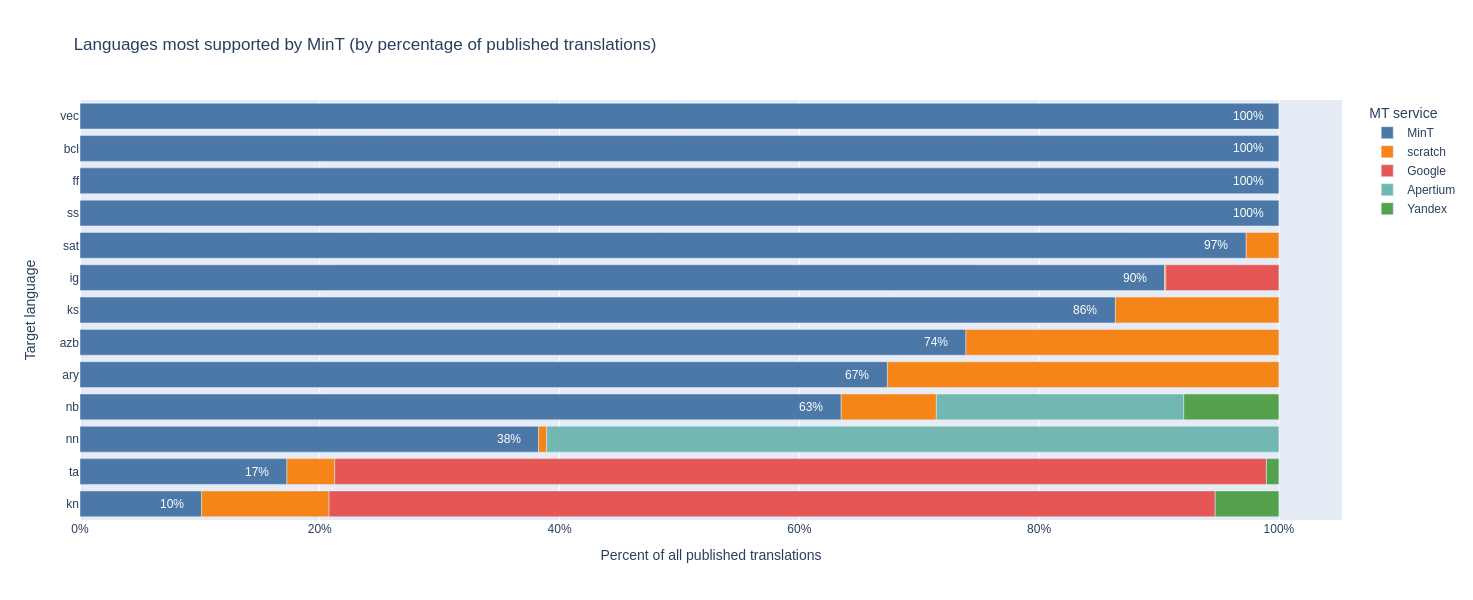

In [60]:
iplot(chart_usage('MinT', chart_height=600, return_fig=True))

### Google

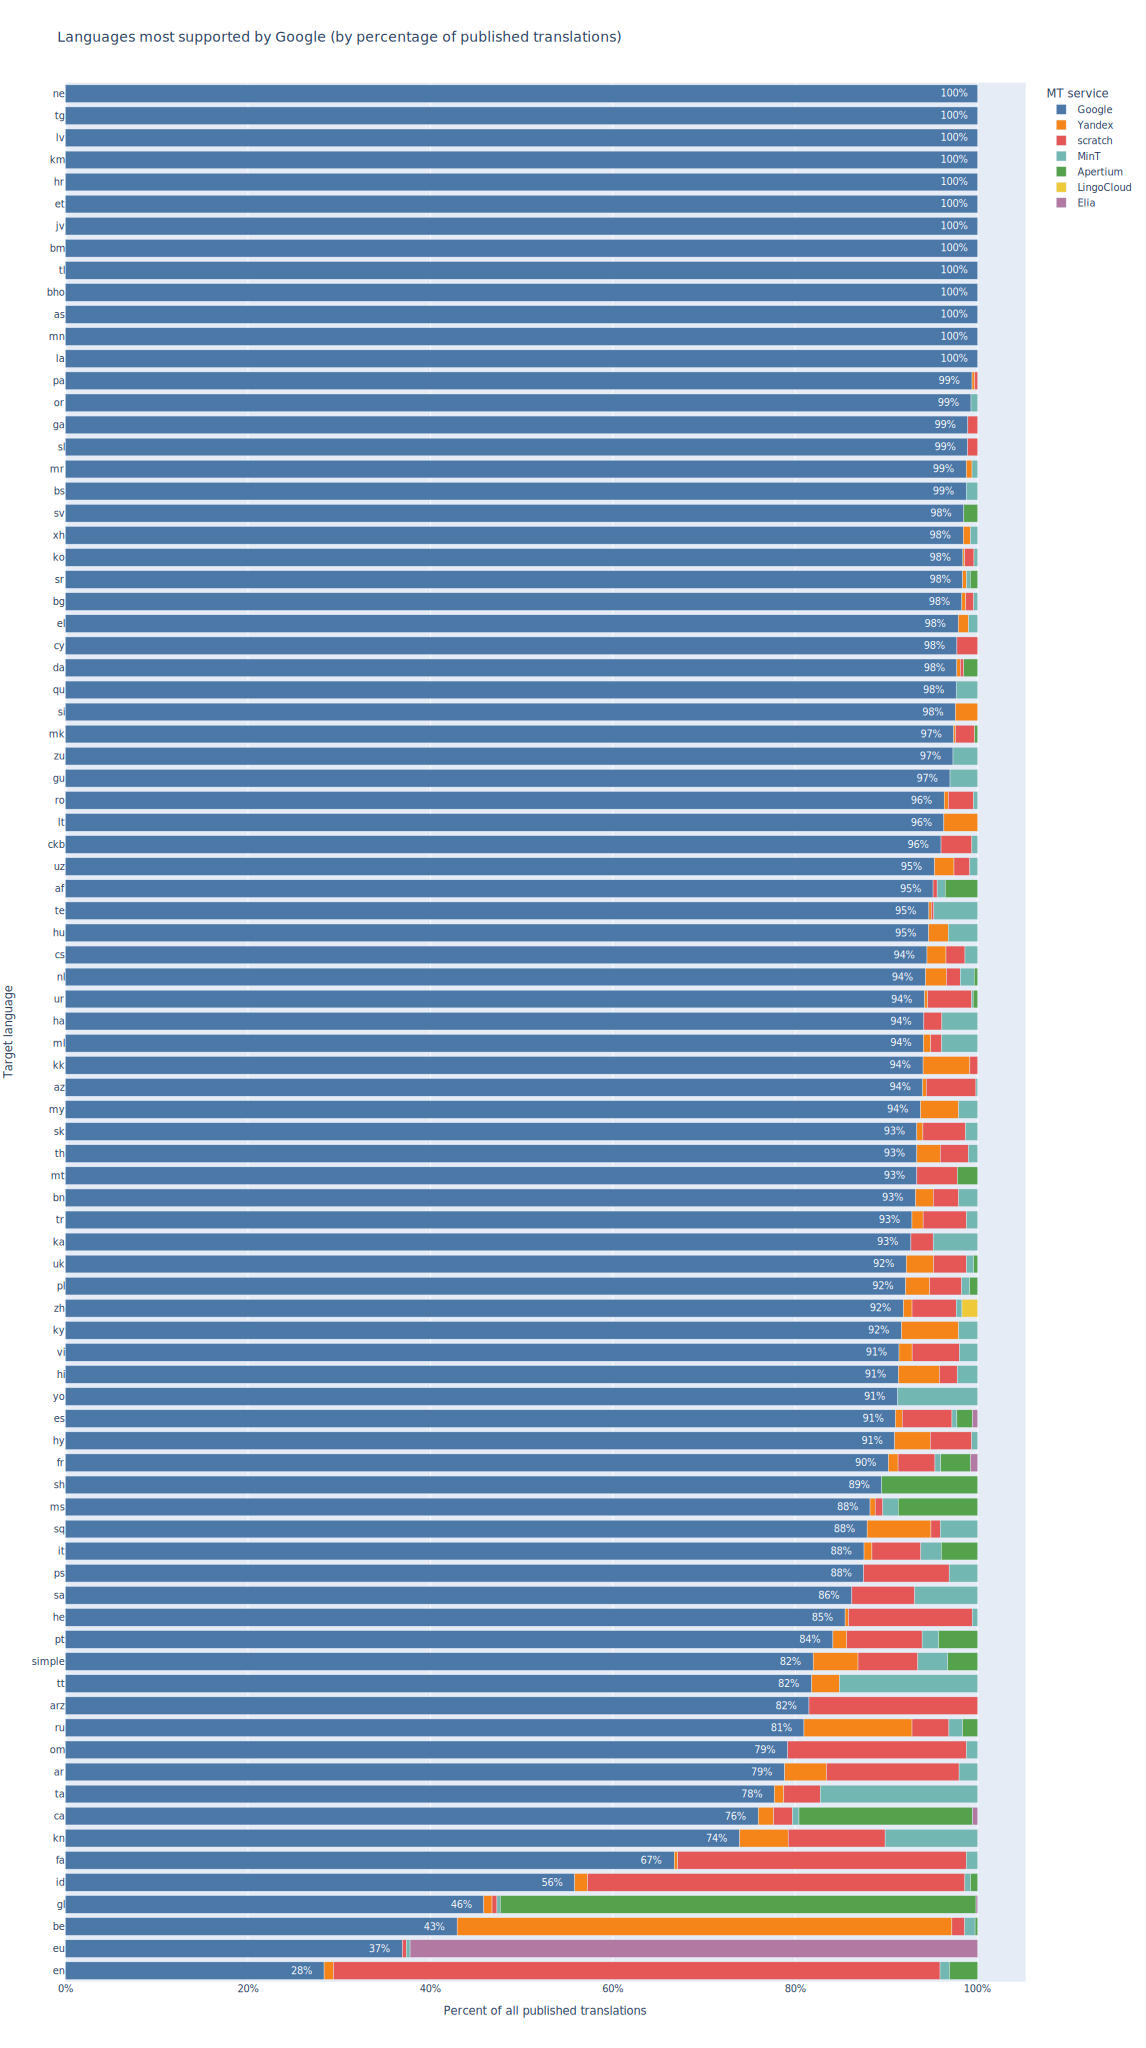

In [37]:
chart_usage('Google', chart_height=2500)

### Yandex

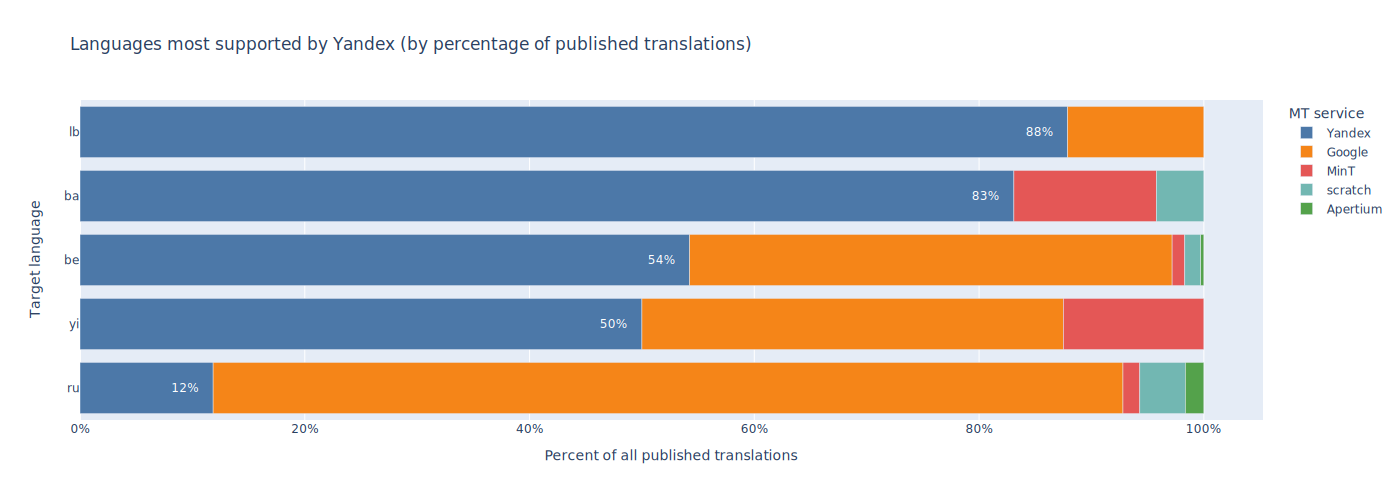

In [38]:
chart_usage('Yandex', chart_height=500)

### Apertium

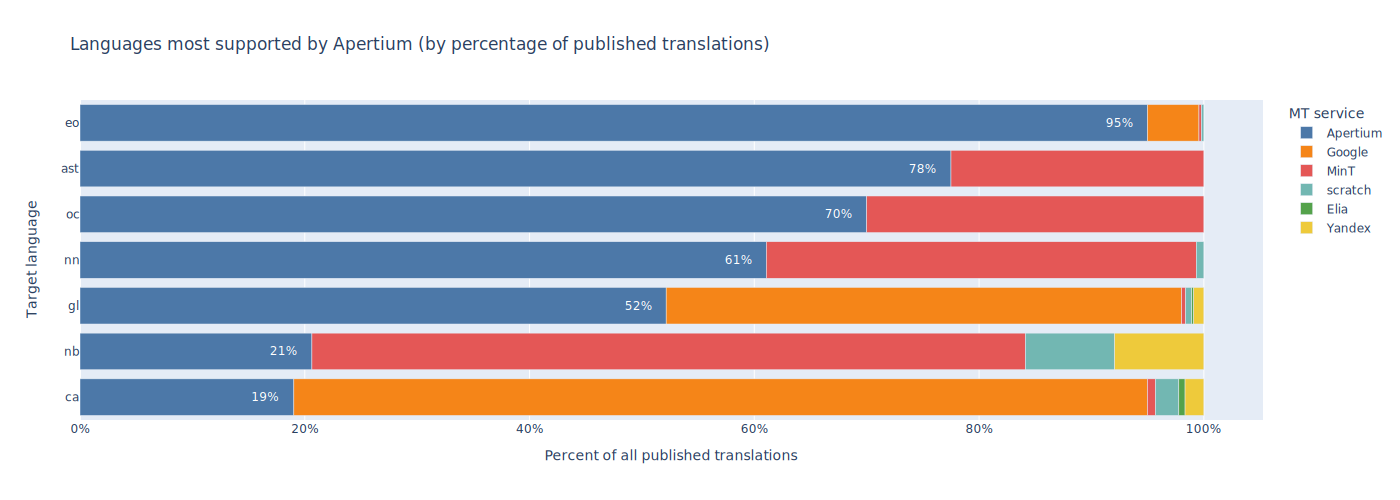

In [39]:
chart_usage('Apertium', chart_height=500)

### Elia

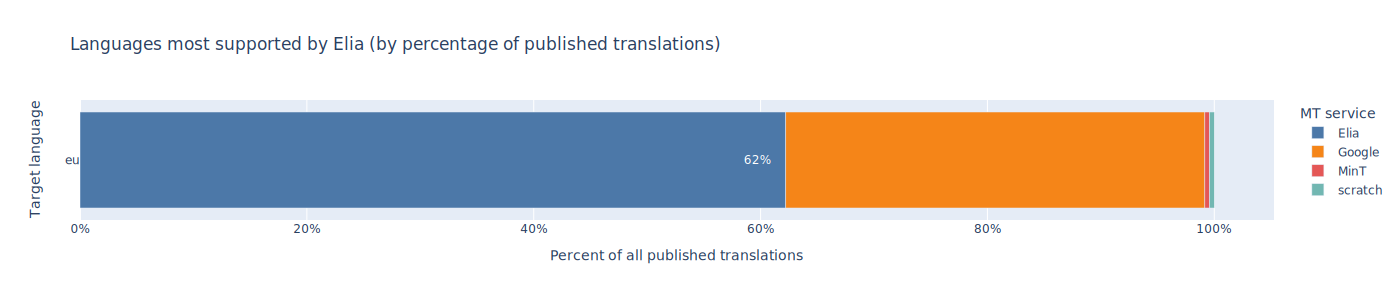

In [43]:
chart_usage('Elia', min_translations=5, min_percent=0.05, chart_height=300)

### LingoCloud

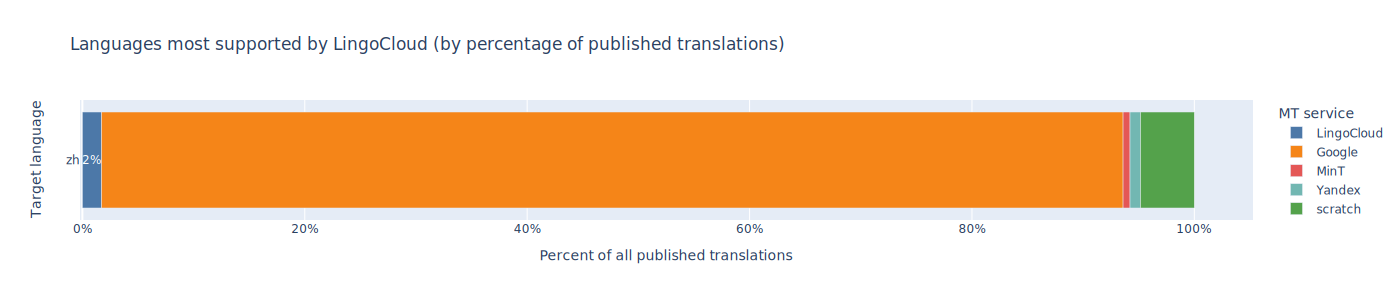

In [46]:
chart_usage('LingoCloud', min_translations=1, min_percent=0, chart_height=300, xlabel_offset=0.009)